In [ ]:
import sklearn
from sklearn.decomposition import NMF
import cv2
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import os
from tools.hsi_to_rgb import hsi_to_rgb
from tqdm import tqdm, trange

In [7]:
def np_normalize(array):
    return (array-np.min(array)) /(np.max(array) - np.min(array))

def spectral_angle(a, b):
    """Compute spectral angle between two vectors a and b."""
    # Ensure inputs are 2D (n_pixels, n_channels)
    numerator = np.sum(a * b, axis=-1)
    denom = np.linalg.norm(a, axis=-1) * np.linalg.norm(b, axis=-1)
    # Clip to avoid numerical errors
    cosine = np.clip(numerator / (denom + 1e-12), -1, 1)
    return np.arccos(cosine)  # in radians

# color the image
cmap = plt.get_cmap('tab10')

In [48]:
#matfile_LR = io.loadmat(r"Datasets/aviva_eye_aligned_r6_filtered.mat")
matfile_LR = io.loadmat(r"Outputs/comparison/avivaface_sr03mm_vs_hr1mm.mat")
print(matfile_LR.keys())

dict_keys(['__header__', '__version__', '__globals__', 'SR', 'HR', 'WL'])


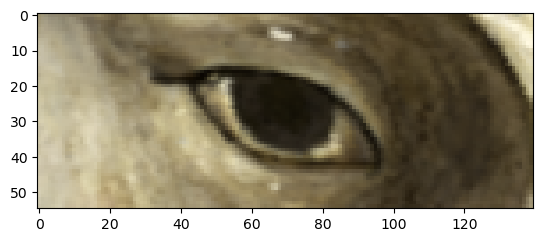

In [9]:
X_LR =np_normalize(matfile_LR["I_MS_LR"])
ch = X_LR.shape[2]
h = X_LR.shape[0]
w = X_LR.shape[1]
wl_cal = np.squeeze(matfile_LR["Wavelengths"])

img_lr_rgb = hsi_to_rgb(X_LR, wl_cal)
fig, axs = plt.subplots()
axs.imshow(img_lr_rgb)

X_LR = X_LR.reshape(-1,ch)


In [10]:
out_folder = r"Outputs/R-PNN/20250716_165350"
matfile = io.loadmat(r"Outputs/R-PNN/20250716_165350/aviva_eye_aligned_r6_filtered_R-PNN.mat")
print(matfile.keys())

dict_keys(['__header__', '__version__', '__globals__', 'I_MS', 'Wavelengths'])


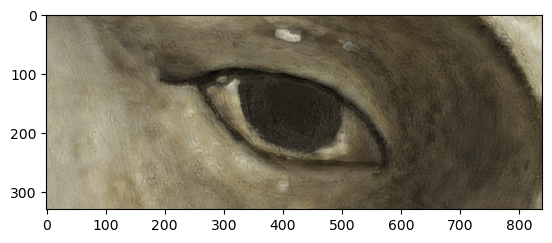

In [11]:
#X = np.transpose(np.squeeze(matfile["I_MS"]), (1,2,0))
X = matfile["I_MS"]
X = np_normalize(X)
ch = X.shape[2]
h_hr = X.shape[0]
w_hr = X.shape[1]

img_hr_rgb = hsi_to_rgb(X, wl_cal)
fig, axs = plt.subplots()
axs.imshow(img_hr_rgb)


X = X.reshape(-1,ch)

# NMF

In [44]:
ncomp = 5
model = NMF(n_components=ncomp, max_iter = 10000)


In [45]:
#W = model.fit_transform(X)
#H = model.components_


In [46]:
W_LR = model.fit_transform(X_LR)
H_LR = model.components_

TypeError: 'list' object is not callable

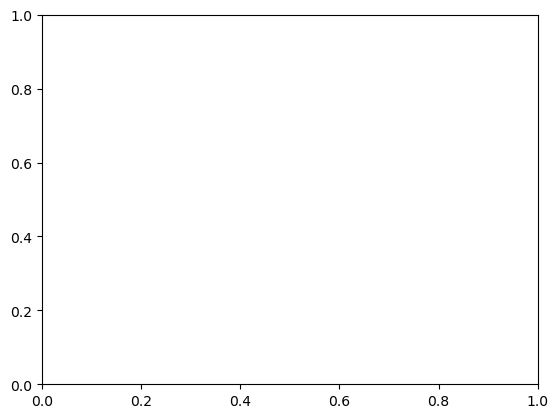

In [47]:
fig, axs = plt.subplots()
for i in range(ncomp):
    axs.plot(H_LR[i,:], label = f"{i+1}", color = cmap(i))
plt.legend()

In [16]:
sam = np.zeros((X_LR.shape[0], ncomp))
for j in range(ncomp):
    for i in range(X_LR.shape[0]):
        sam[i,j] = spectral_angle(X_LR[i,:], H_LR[j,:])


In [17]:
idx_min = np.zeros(sam.shape[0])
threshold = 0.1 # radians
for i in range(sam.shape[0]):
    best_idx = np.argmin(sam[i,:])
    if sam[i,best_idx]<threshold:
        idx_min[i] = best_idx
    else:
        idx_min[i] = -1

In [18]:
# color the pixel in the appropriate endmember class
img = X_LR.reshape(h,w,ch)
img = np.sum(img, 2)
idx_belong = idx_min.reshape(h,w)

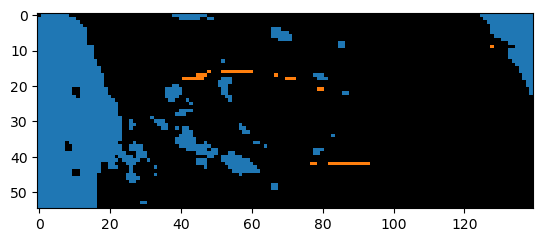

In [19]:
rgb_map = np.zeros((h,w,3))
for i in range(ncomp):
    rgb_map[idx_belong == i] = cmap(i)[:3]
# not assigned pixels will remain black

fig, axs = plt.subplots()
axs.imshow(rgb_map)

In [20]:
# now do the same with the HR image
sam_hr = np.zeros((X.shape[0], ncomp))
for j in range(ncomp):
    for i in range(X.shape[0]):
        sam_hr[i,j] = spectral_angle(X[i,:], H_LR[j,:])

l1_hr = np.zeros((X.shape[0], ncomp))
for j in range(ncomp):
    for i in range(X.shape[0]):
        l1_hr[i,j] = np.linalg.norm((X[i,:] - H_LR[j,:]), ord=1)

idx_min_sam_hr = (-1)*np.ones(sam_hr.shape[0])
threshold_sam = 0.17 # radians
for i in range(sam_hr.shape[0]):
    best_idx = np.argmin(sam_hr[i,:])
    if sam_hr[i,best_idx]<threshold:
        idx_min_sam_hr[i] = best_idx

idx_min_l1_hr = (-1)*np.ones(l1_hr.shape[0])
# threshold_l1 = 0.17 # radians
for i in range(l1_hr.shape[0]):
    best_idx = np.argmin(l1_hr[i,:])
    idx_min_l1_hr[i] = best_idx
        


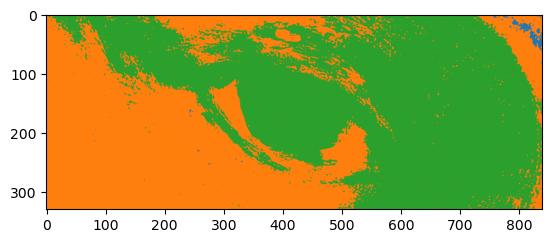

In [21]:
# color the pixel in the appropriate endmember class

#img_hr = X.reshape(h_hr,w_hr,ch)
#img_hr = np.sum(img_hr, 2)

#idx_belong_hr = idx_min_sam_hr.reshape(h_hr,w_hr)
idx_belong_hr = idx_min_l1_hr.reshape(h_hr,w_hr)

rgb_map_hr = np.zeros((h_hr,w_hr,3))
for i in range(ncomp):
    rgb_map_hr[idx_belong_hr == i] = cmap(i)[:3]
# pixel with -1 remain black

fig, axs = plt.subplots()
axs.imshow(rgb_map_hr)

# NFINDR

In [12]:
# try with NFINDR

import pysptools
from pysptools.eea import NFINDR
from pysptools.util import normalize

In [23]:
X_LR_normalized = X_LR / np.linalg.norm(X_LR, axis=0, keepdims=True)

In [24]:
n_endmembers = 10

nfindr = NFINDR()
# endmembers = nfindr.extract(X_LR.reshape(h,w,ch), n_endmembers, maxit=100, normalize=False) 
endmembers = nfindr.extract(X_LR_normalized.reshape(h,w,ch), n_endmembers, maxit=100, normalize=False) # if want endmembers with SAM


Extracted Endmembers Shape: (10, 1156)


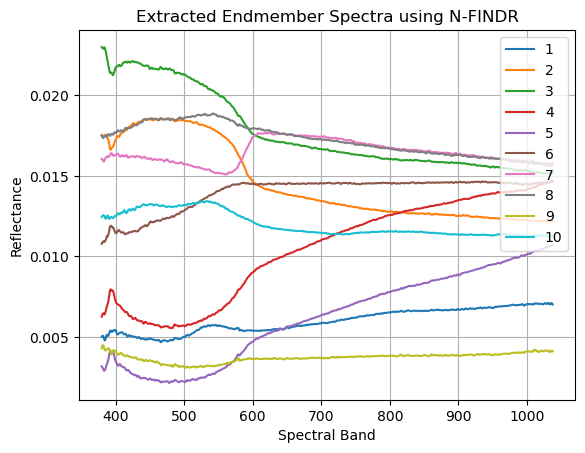

In [25]:

# Find the indices of the endmembers
indices = []
for em in endmembers:
    distances = np.linalg.norm(X_LR - em, axis=1)
    idx = np.argmin(distances)
    indices.append(idx)

# Find the color of the endmembers and save them as a colormap
img_lr_rgb_flat = img_lr_rgb.reshape(h*w,3)
colors_em = []
for em in range(n_endmembers):
    colors_em.append(img_lr_rgb_flat[indices[em],:])

# cmap = colors_em # use the colors of the pixels 
# or use the colors of tab10 as list
c = plt.get_cmap('tab10')
cmap = []
for i in range(10):
    cmap.append(c(i)[:3])
# cmap[3] = [0.7,0.7,0.7] # change the white endmember to a visible color
# cmap[3] = [0,0,1]
# endmembers is of shape (n_endmembers, bands)
print("Extracted Endmembers Shape:", endmembers.shape)

# --- Optional: Visualize the endmember spectra ---
for i in range(n_endmembers):
    plt.plot(wl_cal, endmembers[i], label=f'{i+1}', color = cmap[i])
plt.xlabel('Spectral Band')
plt.ylabel('Reflectance')
plt.legend(loc = "upper right")
plt.title('Extracted Endmember Spectra using N-FINDR')
plt.grid(True)
plt.show()

Find the closest pixels to the endmember

In [26]:
threshold_sam = 0.1 # radians

sam = np.zeros((X_LR.shape[0], n_endmembers))
for j in range(n_endmembers):
    for i in range(X_LR.shape[0]):
        sam[i,j] = spectral_angle(X_LR[i,:], endmembers[j])

l1 = np.zeros((X_LR.shape[0], n_endmembers))
for j in range(n_endmembers):
    for i in range(X_LR.shape[0]):
        l1[i,j] = np.linalg.norm((X_LR[i,:] - endmembers[j,:]), ord=1)

idx_sam_min = np.zeros(sam.shape[0])
for i in range(sam.shape[0]):
    best_idx = np.argmin(sam[i,:])
    if sam[i,best_idx]<threshold_sam:
        idx_sam_min[i] = best_idx
    else:
        idx_sam_min[i] = -1
idx_sam_belong = idx_sam_min.reshape(h,w)

threshold_l1 = 10000
idx_l1_min = np.zeros(l1.shape[0])
for i in range(l1.shape[0]):
    best_idx = np.argmin(l1[i,:])
    if l1[i,best_idx]<threshold_l1:
        idx_l1_min[i] = best_idx
    else:
        idx_l1_min[i] = -1
idx_l1_belong = idx_l1_min.reshape(h,w)

# color the pixel in the appropriate endmember class
#img = X_LR.reshape(h,w,ch)
#img = np.sum(img, 2)



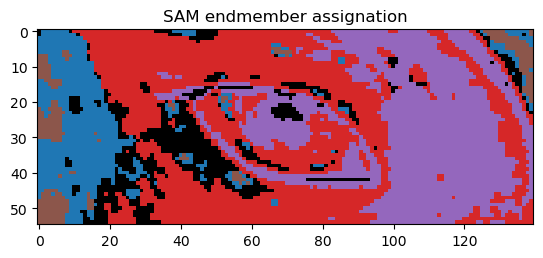

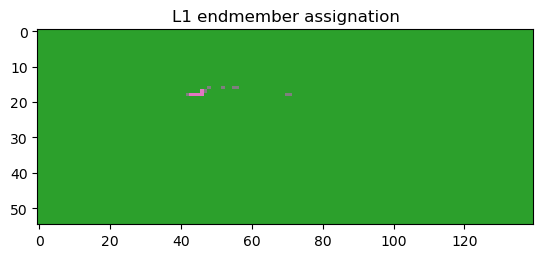

In [27]:
# color the image
sam_rgb_map = np.zeros((h,w,3))
for i in range(n_endmembers):
    sam_rgb_map[idx_sam_belong == i] = cmap[i]


fig, axs = plt.subplots()
axs.imshow(sam_rgb_map)
axs.set_title("SAM endmember assignation");

# color the image
l1_lr_map = np.zeros((h,w,3))
for i in range(n_endmembers):
    l1_lr_map[idx_l1_belong == i] = cmap[i]


fig1, axs1 = plt.subplots()
axs1.imshow(l1_lr_map)
axs1.set_title("L1 endmember assignation");

In [28]:

sam_hr = np.zeros((X.shape[0], n_endmembers))
for j in range(n_endmembers):
    for i in range(X.shape[0]):
        sam_hr[i,j] = spectral_angle(X[i,:], endmembers[j])

l1_hr = np.zeros((X.shape[0], n_endmembers))
for j in range(n_endmembers):
    for i in range(X.shape[0]):
        l1_hr[i,j] = np.linalg.norm((X[i,:] - endmembers[j,:]), ord=1)

idx_sam_hr_min = np.zeros(sam_hr.shape[0])
for i in range(sam_hr.shape[0]):
    best_idx = np.argmin(sam_hr[i,:])
    if sam_hr[i,best_idx]<threshold_sam:
        idx_sam_hr_min[i] = best_idx
    else:
        idx_sam_hr_min[i] = -1
idx_sam_hr_belong = idx_sam_hr_min.reshape(h_hr,w_hr)


idx_l1_hr_min = np.zeros(l1_hr.shape[0])
for i in range(l1_hr.shape[0]):
    best_idx = np.argmin(l1_hr[i,:])
    if l1_hr[i,best_idx]<threshold_l1:
        idx_l1_hr_min[i] = best_idx
    else:
        idx_l1_hr_min[i] = -1
idx_l1_hr_belong = idx_l1_hr_min.reshape(h_hr,w_hr)


Text(0.5, 1.0, 'HR L1 endmember assignation')

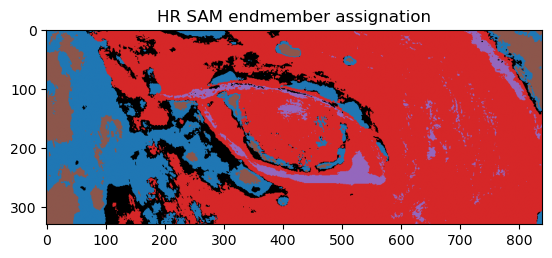

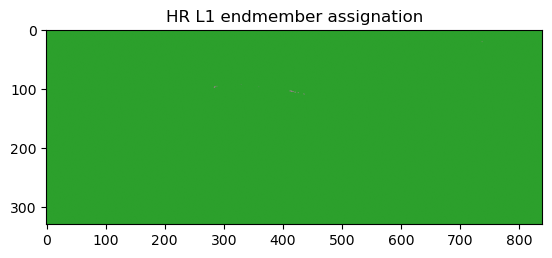

In [29]:
# color the image
sam_hr_rgb_map = np.zeros((h_hr,w_hr,3))
for i in range(n_endmembers):
    # rgb_map[idx_belong == i] = cmap(i)[:3]
    sam_hr_rgb_map[idx_sam_hr_belong == i] = cmap[i]


fig, axs = plt.subplots()
axs.imshow(sam_hr_rgb_map)
axs.set_title("HR SAM endmember assignation")

# color the image
l1_hr_map = np.ones((h_hr,w_hr,3))
for i in range(n_endmembers):
    # rgb_map[idx_belong == i] = cmap(i)[:3]
    l1_hr_map[idx_l1_hr_belong == i] = cmap[i]
l1_hr_map[idx_l1_hr_belong == -1] = [0,0,0]

fig1, axs1 = plt.subplots()
axs1.imshow(l1_hr_map)
axs1.set_title("HR L1 endmember assignation")

In [30]:
"""
# now do the same with the HR image
sam_hr = np.zeros((X.shape[0], n_endmembers))
for j in range(sam_hr.shape[1]):
    for i in range(X.shape[0]):
        sam_hr[i,j] = spectral_angle(X[i,:], endmembers[j])

idx_min_hr = np.zeros(sam_hr.shape[0])
threshold = 0.17 # radians
for i in range(sam_hr.shape[0]):
    best_idx = np.argmin(sam_hr[i,:])
    if sam_hr[i,best_idx]<threshold:
        idx_min_hr[i] = best_idx
    else:
        idx_min_hr[i] = -1

# color the pixel in the appropriate endmember class
#img_hr = X.reshape(h_hr,w_hr,ch)
# img_hr = np.sum(img_hr, 2)

idx_belong_hr = idx_min_hr.reshape(h_hr,w_hr)

rgb_map_hr = np.ones((h_hr,w_hr,3))
for i in range(n_endmembers):
    rgb_map_hr[idx_belong_hr == i] = cmap[i]
rgb_map_hr[idx_belong_hr == i] = [0,0,0]

"""

'\n# now do the same with the HR image\nsam_hr = np.zeros((X.shape[0], n_endmembers))\nfor j in range(sam_hr.shape[1]):\n    for i in range(X.shape[0]):\n        sam_hr[i,j] = spectral_angle(X[i,:], endmembers[j])\n\nidx_min_hr = np.zeros(sam_hr.shape[0])\nthreshold = 0.17 # radians\nfor i in range(sam_hr.shape[0]):\n    best_idx = np.argmin(sam_hr[i,:])\n    if sam_hr[i,best_idx]<threshold:\n        idx_min_hr[i] = best_idx\n    else:\n        idx_min_hr[i] = -1\n\n# color the pixel in the appropriate endmember class\n#img_hr = X.reshape(h_hr,w_hr,ch)\n# img_hr = np.sum(img_hr, 2)\n\nidx_belong_hr = idx_min_hr.reshape(h_hr,w_hr)\n\nrgb_map_hr = np.ones((h_hr,w_hr,3))\nfor i in range(n_endmembers):\n    rgb_map_hr[idx_belong_hr == i] = cmap[i]\nrgb_map_hr[idx_belong_hr == i] = [0,0,0]\n\n'

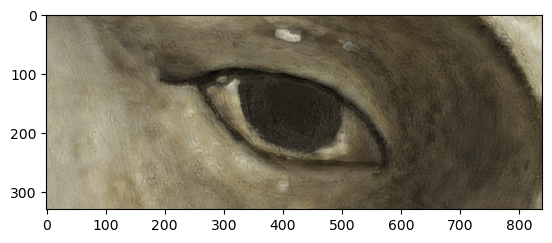

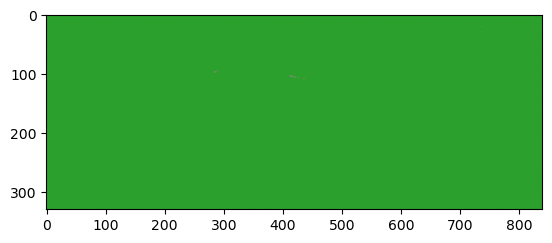

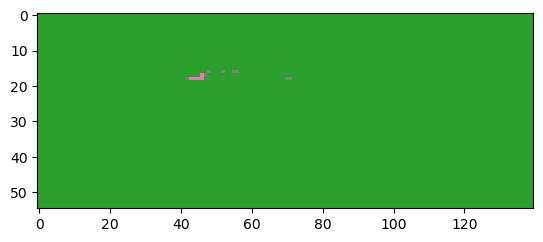

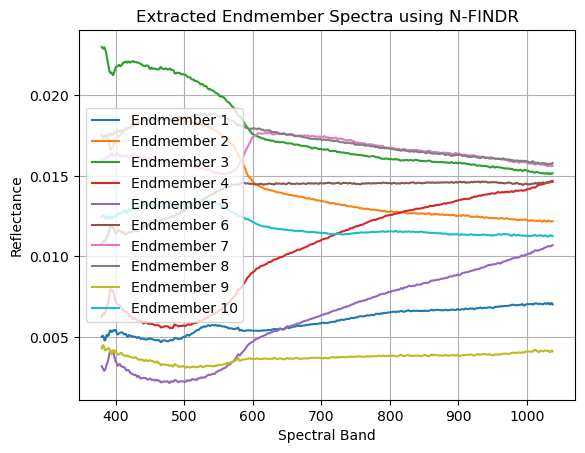

In [31]:
fig0, axs0 = plt.subplots()
axs0.imshow(img_hr_rgb)

fig1, axs1 = plt.subplots()
axs1.imshow(l1_hr_map)

fig2, axs2= plt.subplots()
axs2.imshow(l1_lr_map)

fig2, axs2 = plt.subplots()
# --- Optional: Visualize the endmember spectra ---
for i in range(n_endmembers):
    plt.plot(wl_cal, endmembers[i], label=f'Endmember {i+1}', color = cmap[i])
axs2.set_xlabel('Spectral Band')
axs2.set_ylabel('Reflectance')
axs2.legend()
axs2.set_title('Extracted Endmember Spectra using N-FINDR')
axs2.grid(True)


In [32]:
fig_list = []
axs_list = []
for i in range(n_endmembers+1):
    #fig, axs = plt.subplots()
    #axs.imshow(idx_belong_hr == i, color = cmap[i])
    print(f"{i-1}:", sum(idx_l1_hr_min == i-1))



-1: 0
0: 0
1: 0
2: 276334
3: 0
4: 0
5: 0
6: 14
7: 12
8: 0
9: 0


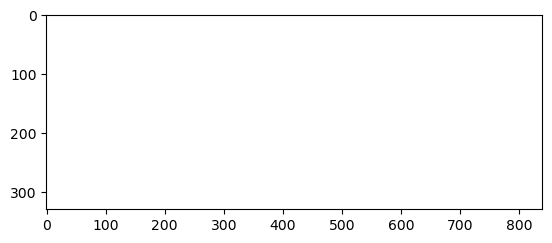

-1: 0


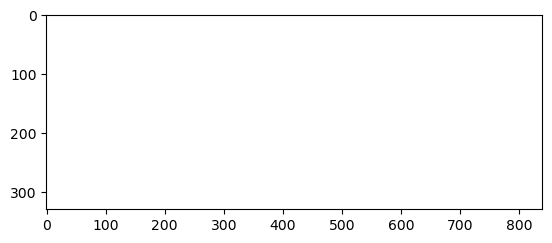

0: 0


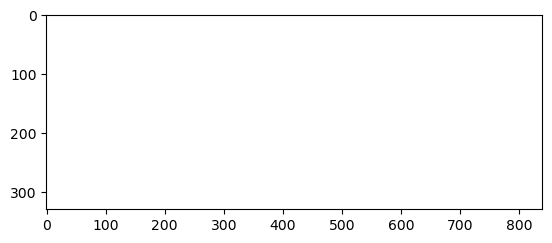

1: 0


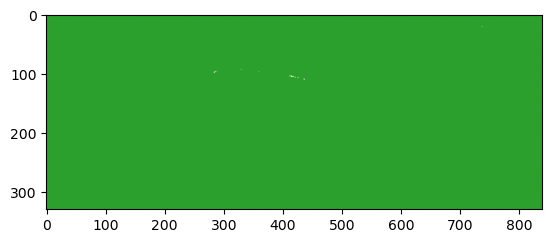

2: 276334


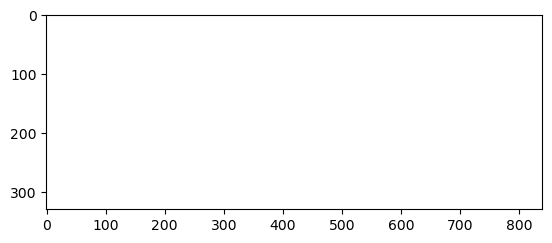

3: 0


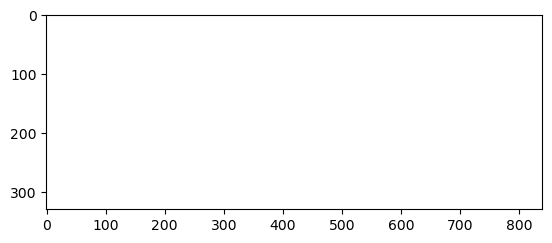

4: 0


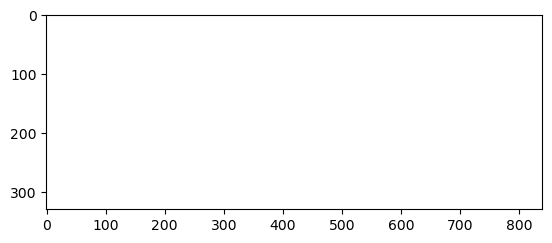

5: 0


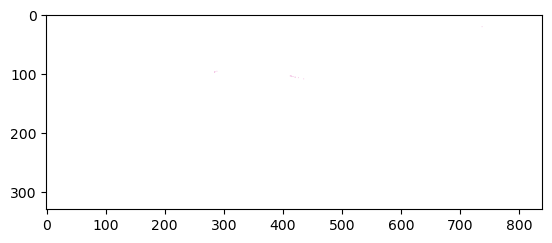

6: 14


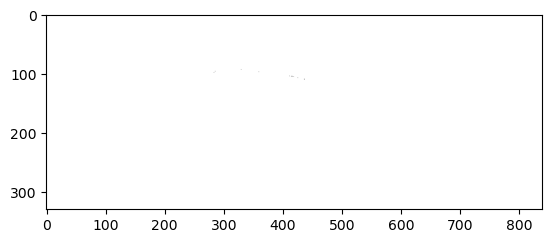

7: 12


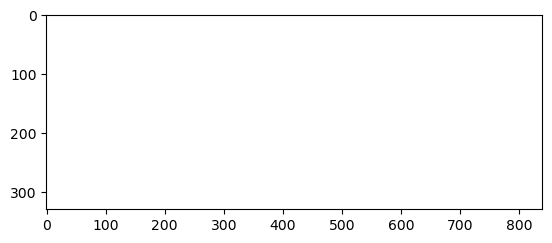

8: 0


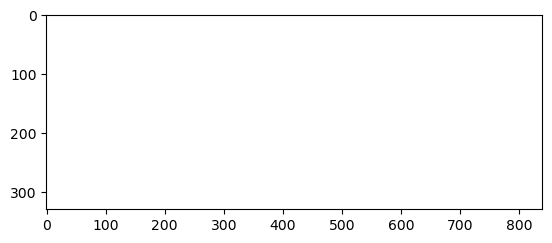

9: 0


In [33]:
fig_list = []
axs_list = []
for i in range(-1,n_endmembers):
    fig, axs = plt.subplots()
    l1_hr_map = np.ones((h_hr,w_hr,3))
    
    if i == -1:
        l1_hr_map[idx_l1_hr_belong == i] = [0,0,0]
        axs.imshow(l1_hr_map)
        plt.show()
    else:
        l1_hr_map[idx_l1_hr_belong == i] = cmap[i]
        axs.imshow(l1_hr_map)
        plt.show()
    print(f"{i}:", sum(idx_l1_hr_min == i))
    fig_list.append(fig)
    axs_list.append(axs)

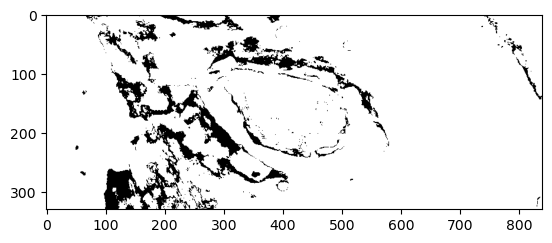

-1: 25242


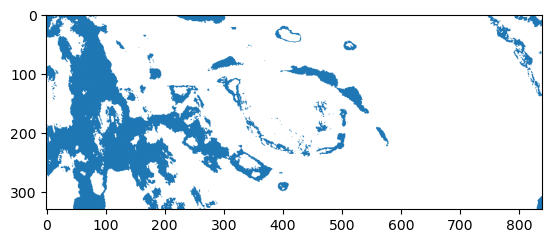

0: 49645


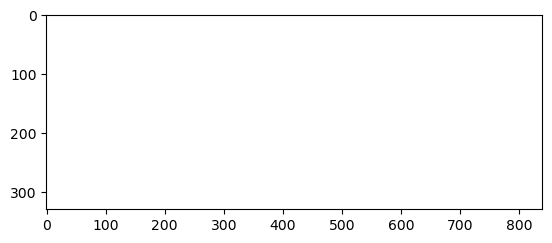

1: 0


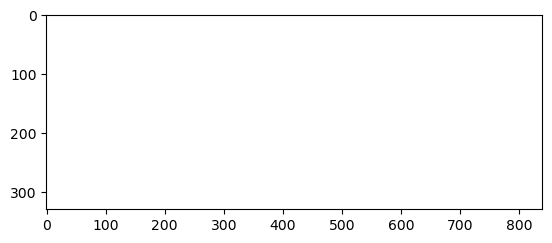

2: 0


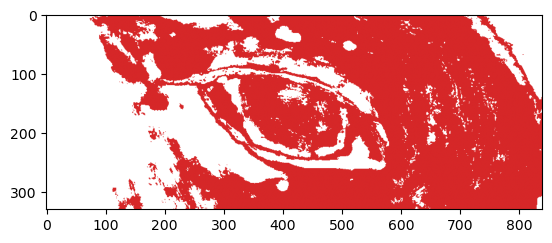

3: 169304


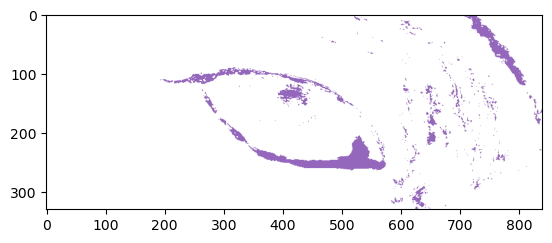

4: 12354


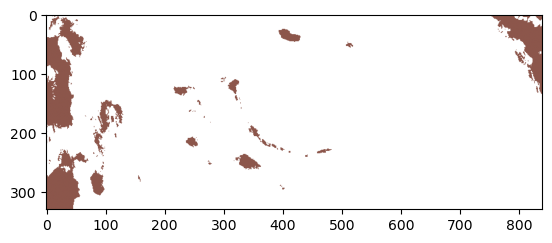

5: 19815


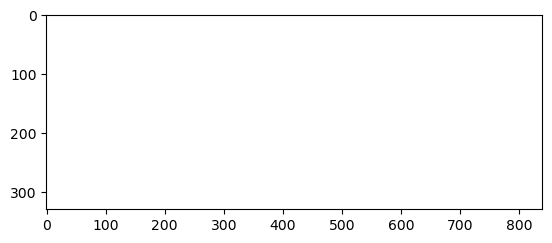

6: 0


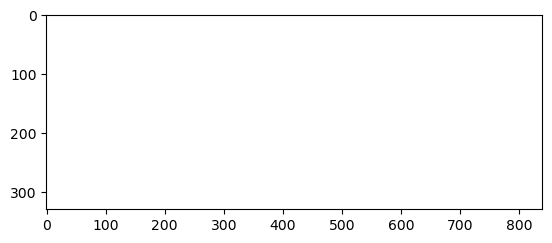

7: 0


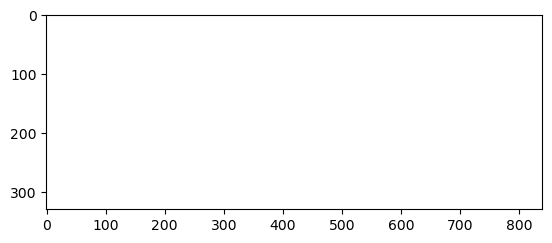

8: 0


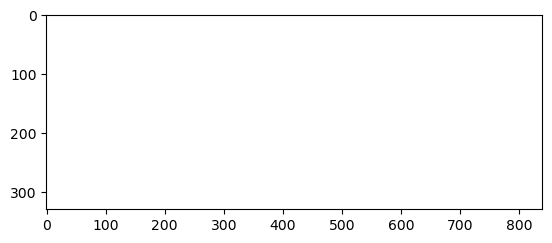

9: 0


In [34]:
fig_list = []
axs_list = []
for i in range(-1,n_endmembers):
    fig, axs = plt.subplots()
    sam_hr_map = np.ones((h_hr,w_hr,3))
    
    if i == -1:
        sam_hr_map[idx_sam_hr_belong == i] = [0,0,0]
        axs.imshow(sam_hr_map)
        plt.show()
    else:
        sam_hr_map[idx_sam_hr_belong == i] = cmap[i]
        axs.imshow(sam_hr_map)
        plt.show()
    print(f"{i}:", sum(idx_sam_hr_min == i))
    fig_list.append(fig)
    axs_list.append(axs)

In [180]:

end_filename = "nfindr_endmembers.mat"
end_savepath = os.path.join(out_folder, end_filename)
print(end_savepath)

map_filename = "nfindr_maps.mat"
map_savepath = os.path.join(out_folder, map_filename)
print(map_savepath)


Outputs/R-PNN/20250710_151732/nfindr_endmembers.mat
Outputs/R-PNN/20250710_151732/nfindr_maps.mat


In [182]:

io.savemat(end_savepath, {"endmembers": endmembers})
io.savemat(map_savepath, {
    "sam_lr_map":idx_sam_belong,
    "sam_hr_map":idx_sam_hr_belong,
    "sam_threshold": threshold_sam,
    "l1_lr_map":idx_l1_belong,
    "l1_hr_map": idx_l1_hr_belong,
    "l1_threshold": threshold_l1,
})




In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import numpy as np

# Assume X is (n_samples, n_features) with raw spectra
X_norm = normalize(X, norm='l2', axis=1)  # Normalize each spectrum to unit length

# Apply standard KMeans, but it behaves like spherical KMeans now
k = 5  # number of clusters
model = KMeans(n_clusters=k, init='k-means++')
labels = model.fit_predict(X_norm)
centroids = normalize(model.cluster_centers_, axis=1)  # Re-normalize centroids


In [39]:
import numpy as np
from sklearn.preprocessing import normalize

def fuzzy_spherical_kmeans(X, K, m=2.0, max_iter=100, tol=1e-5):
    # Normalize data
    X = normalize(X, axis=0)
    N, d = X.shape
    
    # Initialize membership matrix
    U = np.random.dirichlet(np.ones(K), size=N)  # N x K
    
    for _ in range(max_iter):
        # Compute centroids
        M = np.zeros((K, d))
        for k in range(K):
            weights = U[:, k]**m
            M[k] = np.sum(weights[:, None] * X, axis=0)
            M[k] /= np.linalg.norm(M[k])
        
        # Compute cosine dissimilarity
        D = 1 - X @ M.T  # N x K
        
        # Update memberships
        U_new = np.zeros_like(U)
        for i in range(N):
            for k in range(K):
                denom = np.sum([(D[i,k]/D[i,j])**(1/(m-1)) for j in range(K)])
                U_new[i, k] = 1 / denom
        
        # Check convergence
        if np.linalg.norm(U_new - U) < tol:
            break
        U = U_new.copy()
    
    return U, M


U,_= fuzzy_spherical_kmeans(X_LR, 10)

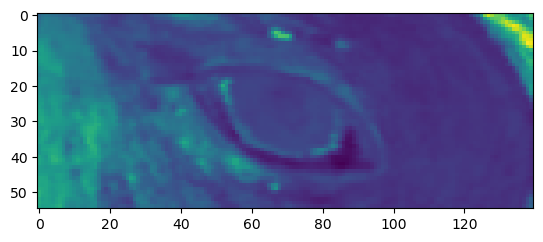

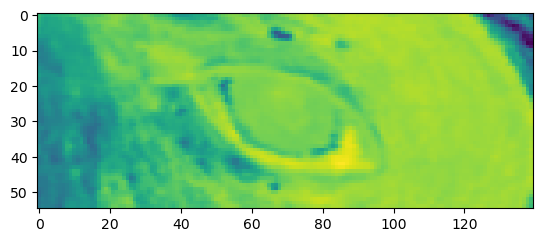

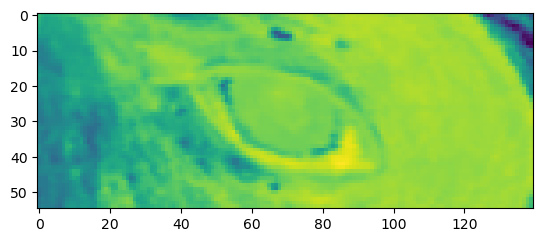

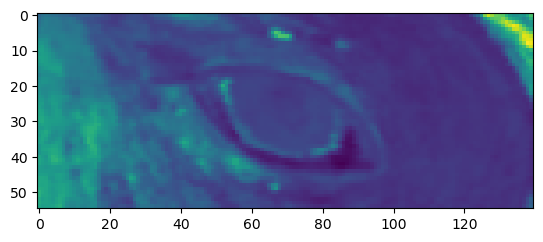

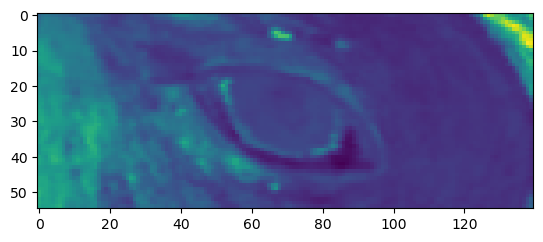

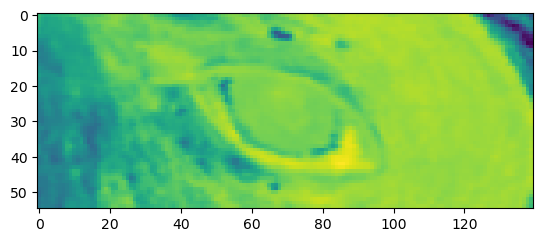

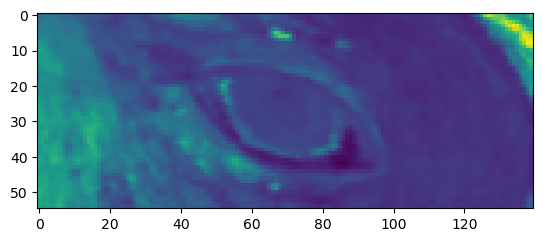

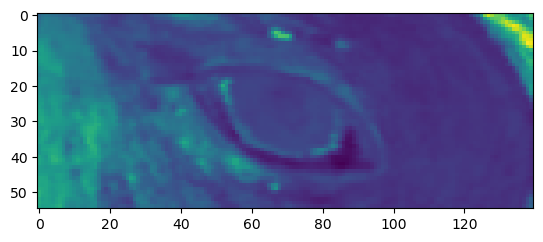

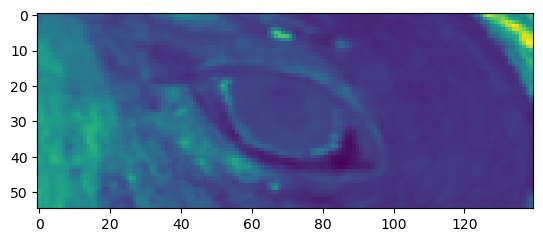

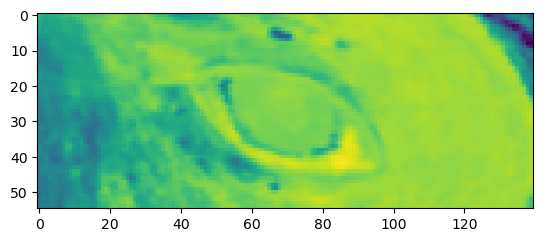

In [41]:
for i in range(10):
    plt.imshow(U.reshape(h,w,-1)[:,:,i])
    plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import numpy as np

# Assume X is (n_samples, n_features) with raw spectra
X_norm = normalize(X_LR, norm='l2', axis=0)  # Normalize each spectrum to unit length

# Apply standard KMeans, but it behaves like spherical KMeans now
k = 5  # number of clusters
model = KMeans(n_clusters=k, init='k-means++')
labels = model.fit_predict(X_norm)
centroids = normalize(model.cluster_centers_, axis=1)  # Re-normalize centroids


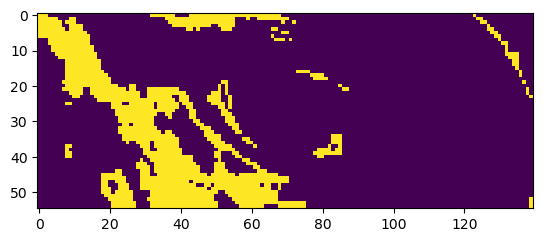

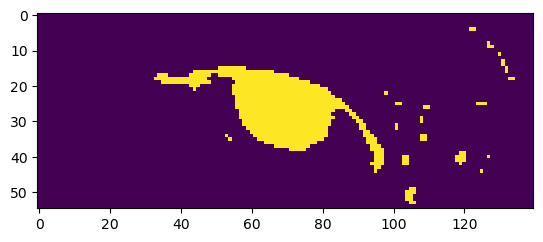

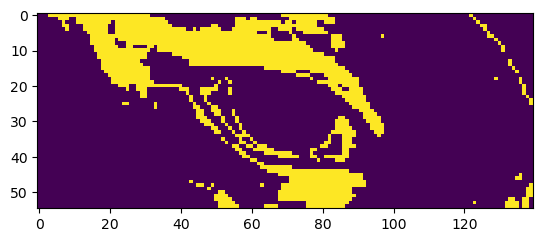

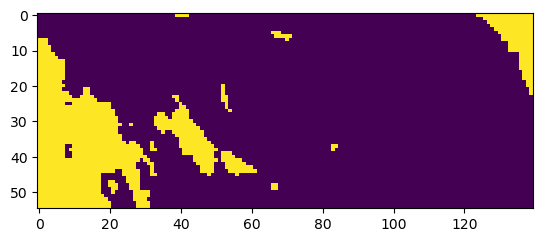

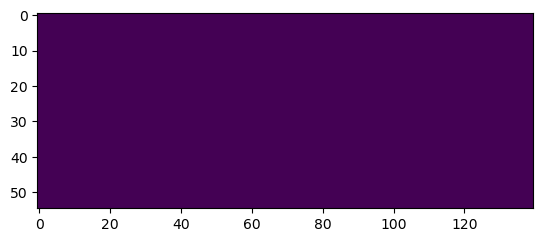

In [43]:

for i in range(k):
    plt.imshow(labels.reshape(h,w) == i+1)
    plt.show()